In [11]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from rmexp import schema

In [20]:
# exps = ['face3pool3pingpong3lego3',
#         'face4pool4pingpong4lego4', 
#         'face5pool4pingpong4lego5',
#         'face5pool5pingpong5lego5',
#         'face5pool6pingpong5lego6',
#         'face5pool6pingpong6lego7',
#         'face5pool7pingpong7lego7',
#         'face8pool8pingpong8lego8']
exps = ['sec5-face3pool3pingpong3lego3ikea3',
        'sec5-face4pool4pingpong4lego4ikea4', 
        'sec5-face5pool4pingpong4lego5ikea5',
        'sec5-face5pool5pingpong5lego5ikea5',
        'sec5-face5pool6pingpong5lego6ikea5',
        'sec5-face5pool6pingpong6lego7ikea6',
        'sec5-face5pool7pingpong7lego7ikea6',
        'sec5-face8pool8pingpong8lego8ikea8'
]

assert len(exps) == len(set(exps)), "redundant!"

exps_clients = map(lambda exp: sum(map(int, re.findall('\d+', exp))) , exps)
print(exps_clients)

schemes = ['baseline', 'cpushares', ]
# apps = ['face', 'lego', 'pingpong', 'pool']
apps = ['face', 'lego', 'pingpong', 'pool', 'ikea']

def pretty_app(app):
    dct = {
        'face': 'FACE',
        'lego': 'LEGO',
        'pingpong': 'PING PONG',
        'pool': 'POOL',
        'ikea': 'IKEA'
    }
    return dct[app]

def pretty_scheme(scheme):
    dct = {
        'baseline': 'Original Gabriel',
        'cpushares': 'Scalable Gabriel',
        'maxmin': 'Our Max-Min',
    }
    return dct[scheme]

app_bounds = {
    'lego': (600, 2700),
    'pingpong': (150, 230),
    'pool': (95, 105),
    'face': (370, 1000),
    'ikea': (600, 2700)
}

[20, 25, 28, 30, 32, 35, 37, 45]


## Max-Sum Utility

In [21]:
# compare total utility of different methods
total_utils = pd.DataFrame()

for scheme in schemes:
    for exp in exps:
        df = pd.read_sql(
            "select sum(utility)/count(distinct name) as utility from ExpLatency where name like %(name)s",
            schema.engine,
            params={'name': exp+'-'+scheme+'%'}
        )
        total_utils = total_utils.append({
            'exp': exp,
            'scheme': scheme,
            'total_utility': df['utility'].iat[0]
        }, ignore_index=True)
        
print(total_utils)

                                   exp     scheme  total_utility
0   sec5-face3pool3pingpong3lego3ikea3   baseline   10036.206665
1   sec5-face4pool4pingpong4lego4ikea4   baseline    9848.742138
2   sec5-face5pool4pingpong4lego5ikea5   baseline    8729.248756
3   sec5-face5pool5pingpong5lego5ikea5   baseline    8605.468775
4   sec5-face5pool6pingpong5lego6ikea5   baseline    7696.172770
5   sec5-face5pool6pingpong6lego7ikea6   baseline    6615.481000
6   sec5-face5pool7pingpong7lego7ikea6   baseline    6104.655706
7   sec5-face8pool8pingpong8lego8ikea8   baseline    5046.176070
8   sec5-face3pool3pingpong3lego3ikea3  cpushares    8626.979619
9   sec5-face4pool4pingpong4lego4ikea4  cpushares    9026.240736
10  sec5-face5pool4pingpong4lego5ikea5  cpushares   11549.027323
11  sec5-face5pool5pingpong5lego5ikea5  cpushares   11695.675976
12  sec5-face5pool6pingpong5lego6ikea5  cpushares   11561.987471
13  sec5-face5pool6pingpong6lego7ikea6  cpushares   10891.804472
14  sec5-face5pool7pingpo

<IPython.core.display.Javascript object>


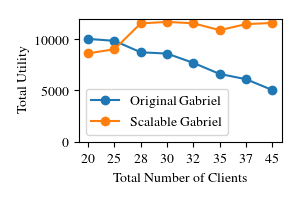

In [22]:
%matplotlib notebook

plt.figure(figsize=(3,2))
for scheme in schemes:
    plt.plot('exp', 'total_utility', 'o-', data=total_utils[total_utils['scheme'] == scheme], label=pretty_scheme(scheme))
plt.ylim([0, None])
plt.xticks(exps, exps_clients)
plt.xlabel('Total Number of Clients')
plt.ylabel('Total Utility')
plt.legend()
plt.tight_layout()
plt.savefig('figs/fig-alloc-max-util.pdf')

In [18]:
def exp_app_clients(name):
    r = re.findall('\d+', name)
    r = map(int, r)
    return dict(zip(['face', 'pool', 'pingpong', 'lego', 'ikea'], r))

<IPython.core.display.Javascript object>


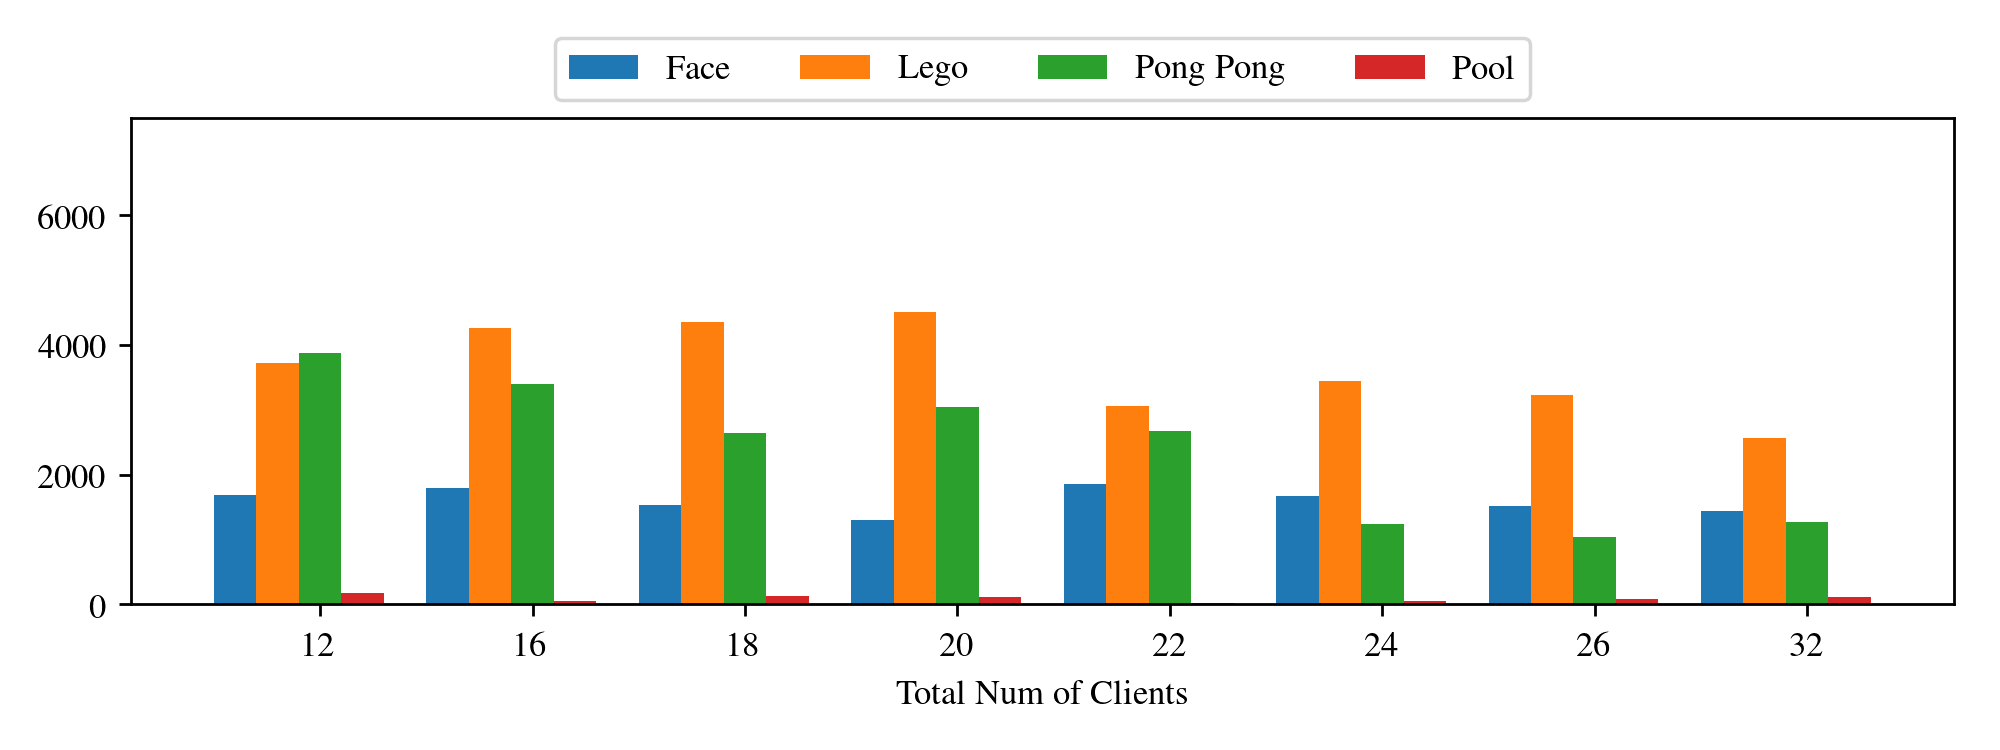

<IPython.core.display.Javascript object>


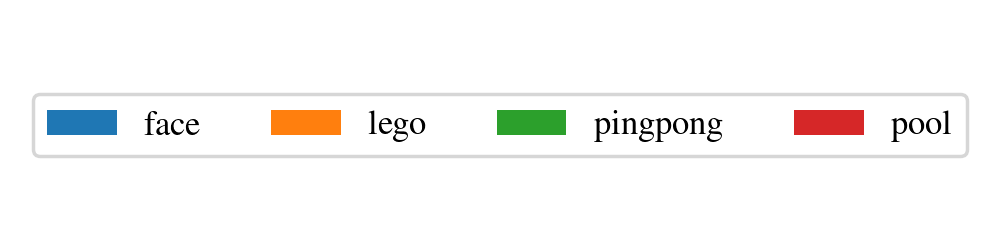

<IPython.core.display.Javascript object>


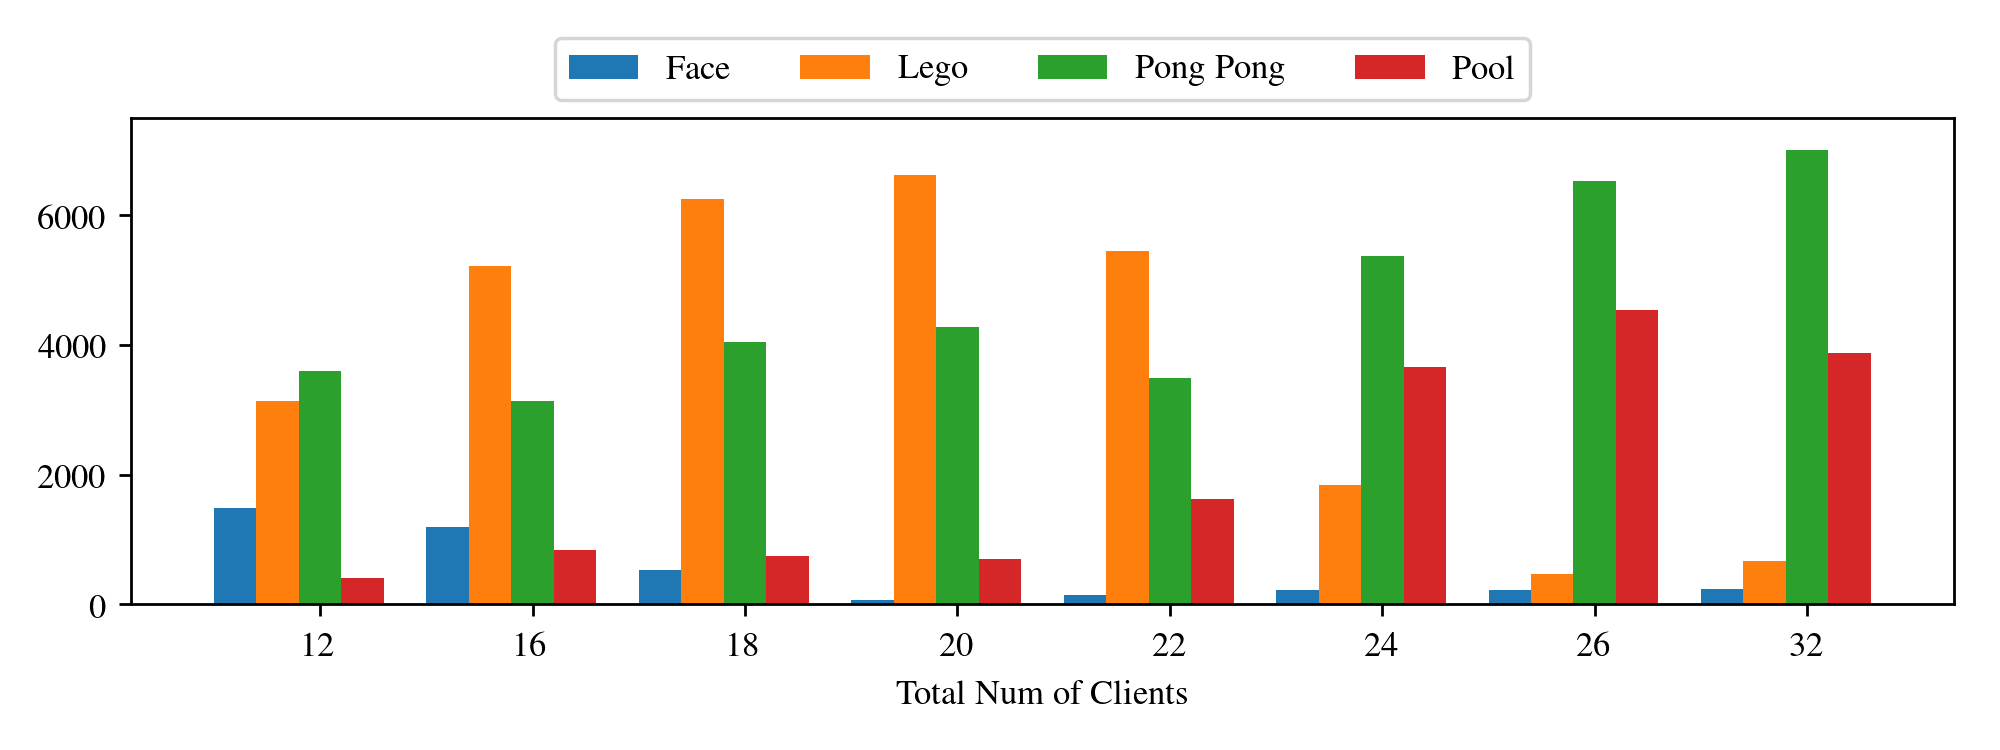

<IPython.core.display.Javascript object>


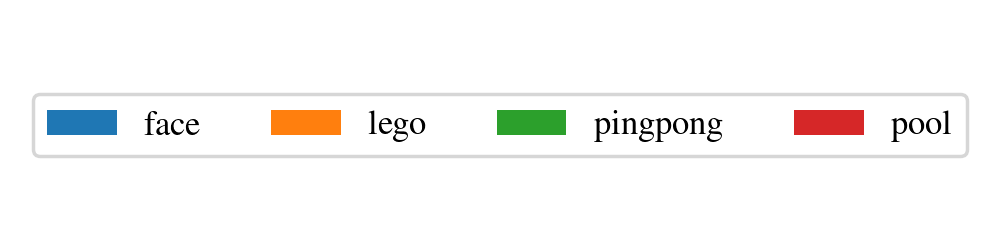

In [275]:
# plot breakdowns of individual apps

for scheme in schemes:
    app_utils = pd.DataFrame()
    
    for exp in exps:
        df = pd.read_sql(
            "select app, sum(utility) as utility from ExpLatency where name=%(name)s group by app",
            schema.engine,
            params={'name': exp+'-'+scheme}
        )
        df['exp'] = exp
        
        app_utils = app_utils.append(df, ignore_index=True)
        
#     print(app_utils)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(exps))
    width = .2
    
    fig_legend = plt.figure(figsize=(4,1))
    
    lines=[]
    for i, app in enumerate(apps):
        ln = ax.bar(ind + width*i, app_utils[app_utils['app']==app]['utility'], width, label=pretty_app(app))
        lines.append(ln)
    fig_legend.legend(lines, apps, 'center', ncol=4)
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(exps_clients)
    ax.set_xlabel('Total Num of Clients')
    ax.set_ylim([0, 7500])
    fig.set_size_inches((8,3))
    ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)
    fig.tight_layout()
    fig.savefig('fig-alloc-{}.pdf'.format(scheme), bbox_inches='tight')
            

fig_legend.show()

In [23]:
# plot 90%-tile/avg latencies of individual apps
def plot_latency(exps, schemes, apps, prefix):

    for scheme in schemes:
        app_latency = pd.DataFrame()

        for exp in exps:
            df = pd.read_sql(
                "select name, app, reply as latency from ExpLatency where name like %(name)s",
                schema.engine,
                params={'name': exp+'-'+scheme+'%',}
            )

            for app in apps:
                df_app = df[df['app']==app]
                latency = np.percentile(df_app['latency'].values, 90)  # 90%-tile
                count = df_app['latency'].count()

                app_latency = app_latency.append({
                    'exp': exp,
                    'app': app,
                    'latency': latency,
                    'count': count
                    }, ignore_index=True)

        fig, ax = plt.subplots()
        ind = np.arange(len(exps))
        
        legend_lns = []

        # per-app latency
        width = .18

        for i, app in enumerate(apps):
            x = ind + width*i
            y = app_latency[app_latency['app']==app]['latency'].values

            lb, ub = app_bounds[app]

            y1 = np.ones_like(y)
            y1[y < lb] = y[y < lb] / lb
            y1[np.logical_and(lb <= y, y <= ub)] = 1. + (y[np.logical_and(lb <= y, y <= ub)] - lb) / (ub - lb)
            y1[y > ub] = 1. + y[y > ub] / ub

            ln = ax.bar(x, y1, width, label=pretty_app(app))
            legend_lns.append(ln)

        ax.hlines(1., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')
        ax.hlines(2., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')

        ax.set_yticks([1., 2.])
        ax.set_yticklabels(['Tight\n bound', 'Loose\n bound'])
        ax.set_xticks(ind + width * len(apps) / 2 )
        ax.set_xticklabels(exps_clients)
        ax.set_xlabel('Total Number of Clients')
        ax.set_ylabel('Normalized Latency')
        ax.set_ylim([0, 4.])
#         ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4, handletextpad=.3)

        fig.set_size_inches((4, 2))
        fig.tight_layout()
        print("Saving", prefix, scheme)
        fig.savefig('fig-{}-latency-{}.pdf'.format(prefix, scheme), bbox_inches='tight')
        
        # save legend to separate figure
        fig_legend = plt.figure(figsize=(4, .25))
        fig_legend.legend(legend_lns, map(pretty_app, apps), 'center', ncol=4)
        fig_legend.savefig('fig-{}-latency-legend.pdf'.format(prefix), bbox_inches='tight')


<IPython.core.display.Javascript object>


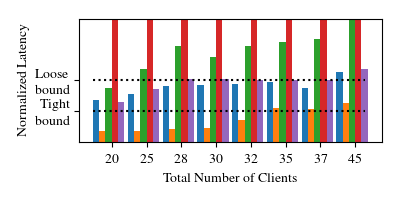

('Saving', 'alloc', 'baseline')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


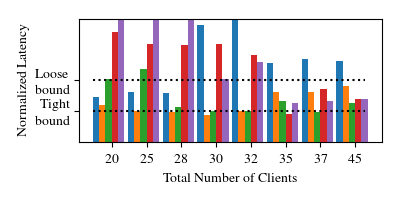

('Saving', 'alloc', 'cpushares')


<IPython.core.display.Javascript object>

In [24]:
%matplotlib notebook
plot_latency(exps, schemes, apps, 'alloc')

<IPython.core.display.Javascript object>


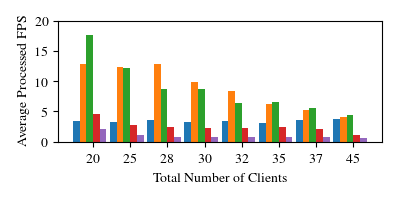

[5 5 5 5 5 5 5 5]
[3.44222222 3.24888889 3.64444444 3.29333333 3.47777778 3.13555556
 3.60888889 3.66888889]
[3 4 4 5 5 6 7 8]
[12.77777778 12.33611111 12.86388889  9.79111111  8.33111111  6.26296296
  5.1968254   4.02638889]
[3 4 4 5 6 6 7 8]
[17.54814815 12.10555556  8.70833333  8.73555556  6.36481481  6.59814815
  5.53333333  4.34027778]
[3 4 5 5 5 5 5 8]
[4.62962963 2.72777778 2.37777778 2.27555556 2.32888889 2.35555556
 2.04       1.03055556]
[3 4 5 5 6 7 7 8]
[2.07777778 1.15277778 0.83777778 0.84       0.77777778 0.7047619
 0.73968254 0.61805556]


<IPython.core.display.Javascript object>


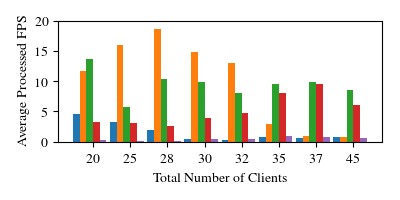

[5 5 5 5 5 5 5 5]
[4.6        3.20666667 1.99555556 0.42222222 0.35555556 0.73111111
 0.68222222 0.76666667]
[3 4 4 5 5 6 7 8]
[11.64444444 15.99722222 18.51944444 14.72888889 13.04222222  2.85555556
  0.99206349  0.82083333]
[3 4 4 5 6 6 7 8]
[13.70740741  5.78611111 10.28055556  9.80666667  8.0462963   9.46851852
  9.86190476  8.60555556]
[3 4 5 5 5 5 5 8]
[3.28888889 3.13888889 2.61555556 3.86222222 4.80888889 8.07777778
 9.50222222 6.12083333]
[3 4 5 5 6 7 7 8]
[0.24814815 0.19444444 0.2        0.47555556 0.4037037  0.94920635
 0.81587302 0.64305556]


In [25]:
# Plot processed fps
for scheme in schemes:
    app_frames = pd.DataFrame()
    
    for exp in exps:
        df = pd.read_sql(
            "select app, count(*)/count(distinct name) as frames from ExpLatency where name like %(name)s group by app",
            schema.engine,
            params={'name': exp+'-'+scheme+'%',}
        )
        
        df['exp'] = exp
        
        app_frames = app_frames.append(df, ignore_index=True)
        
#     print(app_frames)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(exps))
    width = .18
    
    for i, app in enumerate(apps):
        x = ind + width*i
        this_app = app_frames[app_frames['app']==app]
        this_app_clients = np.array([exp_app_clients(name)[app] for name in this_app['exp']])
        print(this_app_clients)
        # y is average fps
        y = this_app['frames'].values / (this_app_clients * 90)
        print(y)
        
        ax.bar(x, y, width, label=pretty_app(app))
    
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(exps_clients)
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Average Processed FPS')
#     ax.set_yticks([0, 5, 10, 15])
    ax.set_ylim([0, 20])
#     ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

    fig.set_size_inches((4, 2.))
    fig.tight_layout()
    fig.savefig('fig-alloc-fps-{}.pdf'.format(scheme), bbox_inches='tight')

## Combined Evaluation

<IPython.core.display.Javascript object>


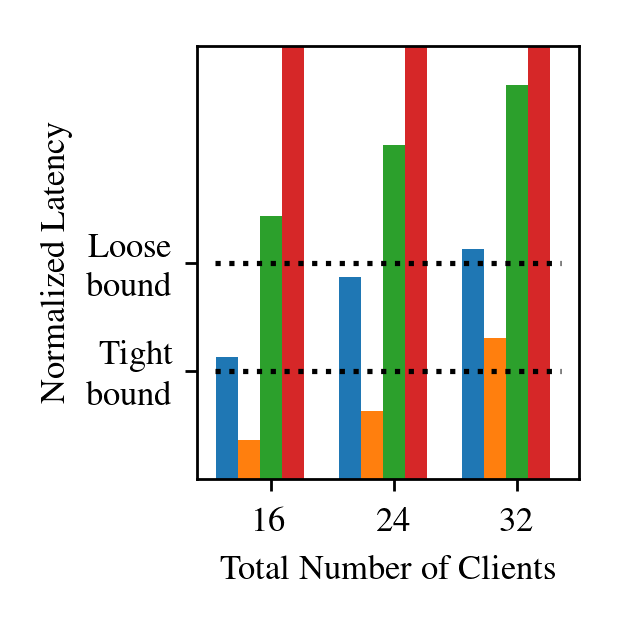

<IPython.core.display.Javascript object>


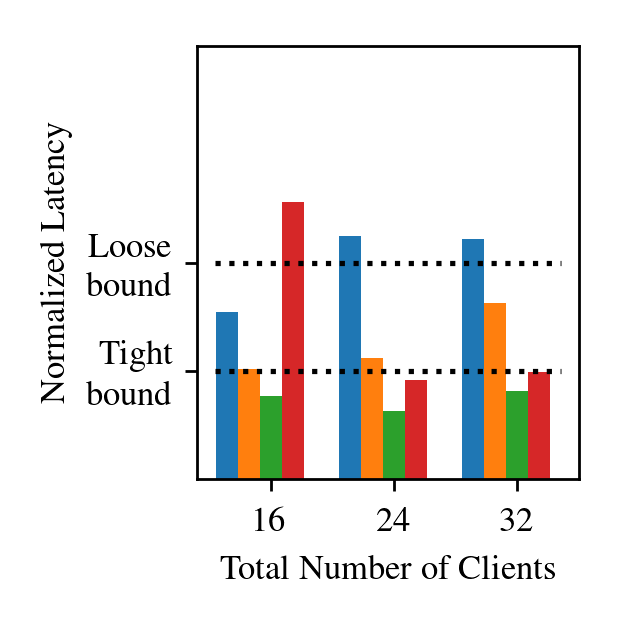

In [292]:
prefix = 'eval'
sec6_exps = [4, 6, 8]
for scheme in ['baseline', 'ours']:
    app_latency = pd.DataFrame()

    for exp in sec6_exps:
        df = pd.read_sql(
            "select name, app, reply as latency from ExpLatency where name=%(name)s",
            schema.engine,
            params={'name': 'sec6-{}-{}'.format(scheme, exp),}
        )

        for app in apps:
            df_app = df[df['app']==app]
            latency = np.percentile(df_app['latency'].values, 90)  # 90%-tile

            app_latency = app_latency.append({
                'exp': exp,
                'app': app,
                'latency': latency,
                }, ignore_index=True)

#     print(app_latency)

    fig, ax = plt.subplots()
    ind = np.arange(len(sec6_exps))

    # per-app latency
    width = .18

    for i, app in enumerate(apps):
        x = ind + width*i
        y = app_latency[app_latency['app']==app]['latency'].values

        lb, ub = app_bounds[app]

        y1 = np.ones_like(y)
        y1[y < lb] = y[y < lb] / lb
        y1[np.logical_and(lb <= y, y <= ub)] = 1. + (y[np.logical_and(lb <= y, y <= ub)] - lb) / (ub - lb)
        y1[y > ub] = 1. + y[y > ub] / ub

        ax.bar(x, y1, width, label=pretty_app(app))

    ax.hlines(1., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')
    ax.hlines(2., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')

    ax.set_yticks([1., 2.])
    ax.set_yticklabels(['Tight\n bound', 'Loose\n bound'])
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(np.array(sec6_exps)*4)
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Normalized Latency')
    ax.set_ylim([0, 4.])
#     ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4, handletextpad=.3)

    fig.set_size_inches((2.5, 2.5))
    fig.tight_layout()
    fig.savefig('fig-{}-latency-{}.pdf'.format(prefix, scheme), bbox_inches='tight')

<IPython.core.display.Javascript object>


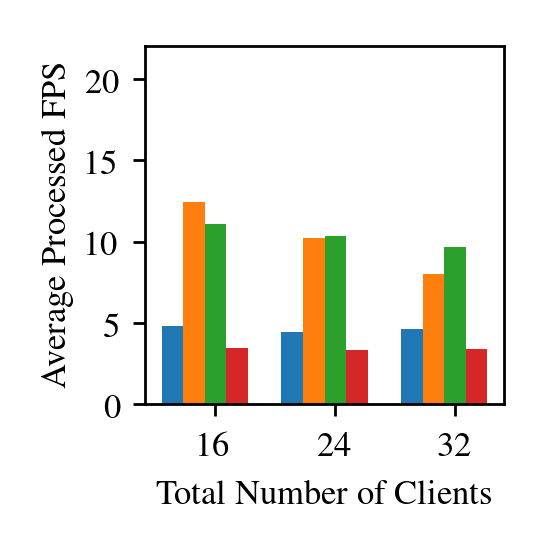

[3 4 4 5 6 6 7 8]
[4.83333333 4.44444444 4.61111111]
[3 4 4 5 6 6 7 8]
[12.44722222 10.24444444  7.98888889]
[3 4 4 5 6 6 7 8]
[11.09166667 10.36944444  9.68055556]
[3 4 4 5 6 6 7 8]
[3.43333333 3.33888889 3.38611111]


<IPython.core.display.Javascript object>


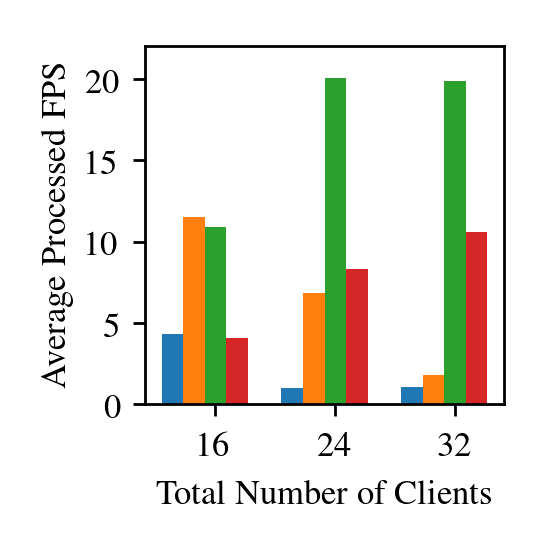

[3 4 4 5 6 6 7 8]
[4.31666667 1.01111111 1.04166667]
[3 4 4 5 6 6 7 8]
[11.48333333  6.81666667  1.83055556]
[3 4 4 5 6 6 7 8]
[10.86388889 20.05833333 19.85277778]
[3 4 4 5 6 6 7 8]
[ 4.075       8.31111111 10.60555556]


In [299]:
# Plot processed fps
for scheme in ['baseline', 'ours']:
    app_frames = pd.DataFrame()
    
    for exp in sec6_exps:
        df = pd.read_sql(
            "select app, count(*)/count(distinct name) as frames from ExpLatency where name like %(name)s group by app",
            schema.engine,
            params={'name': 'sec6-{}-{}'.format(scheme, exp),}
        )
        
        df['exp'] = exp
        
        app_frames = app_frames.append(df, ignore_index=True)
        
#     print(app_frames)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(sec6_exps))
    width = .18
    
    for i, app in enumerate(apps):
        x = ind + width*i
        this_app = app_frames[app_frames['app']==app]
        print(this_app_clients)
        # y is average fps
        y = this_app['frames'].values / (4 * 90)  # hard code
        print(y)
        
        ax.bar(x, y, width, label=pretty_app(app))
    
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(np.array(sec6_exps)*4)  # hard code
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Average Processed FPS')
#     ax.set_yticks([0, 5, 10, 15])
    ax.set_ylim([0, 22])
#     ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

    fig.set_size_inches((2.2, 2.2))
    fig.tight_layout()
    fig.savefig('fig-{}-fps-{}.pdf'.format(prefix, scheme), bbox_inches='tight')